In [1]:
import time
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scvelo as scv
import scanpy
import scipy

from torch import optim
from veloproj import *
from sklearn.decomposition import PCA
from IPython import display
from matplotlib import pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--data-dir', '/data/users/cqiao/notebooks/data/organoids.hdf5',
                               '--model-name', 'scEU_model.cpt',
                               '--exp-name', 'CohAE_scEU',
                               '--device', 'cuda:3',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("3", "1"), ("3", "2")]
k_cluster = "monocle_branch_id"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args):
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())

    model = get_veloAE(
                     adata, 
                     z_dim, 
                     n_genes, 
                     n_cells, 
                     h_dim, 
                     k_dim, 
                     G_embeddings=G_embeddings, 
                     g_rep_dim=g_rep_dim,
                     device=device
                    )
    
    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    
    model.train()
    i, losses = 0, [sys.maxsize]
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_u, tensor_s, tensor_x], model, optimizer)                
        losses.append(loss)
        if i % args.log_interval == 0:
            plt.plot(losses[1:])
            display.clear_output(wait=True)
            plt.show()
            print("Train Epoch: {:2d} Loss: {:.6f}"
                  .format(i, losses[-1]))
    
    plt.plot(losses[1:])
    display.clear_output(wait=True)
    plt.show()
    print(losses[-1])
    torch.save(model.state_dict(), args.model_name)

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.68 0.32]
Filtered out 3746 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3831 × 2000
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'rotated_umap1', 'rotated_umap2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'con

computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scEU_stochastical.png


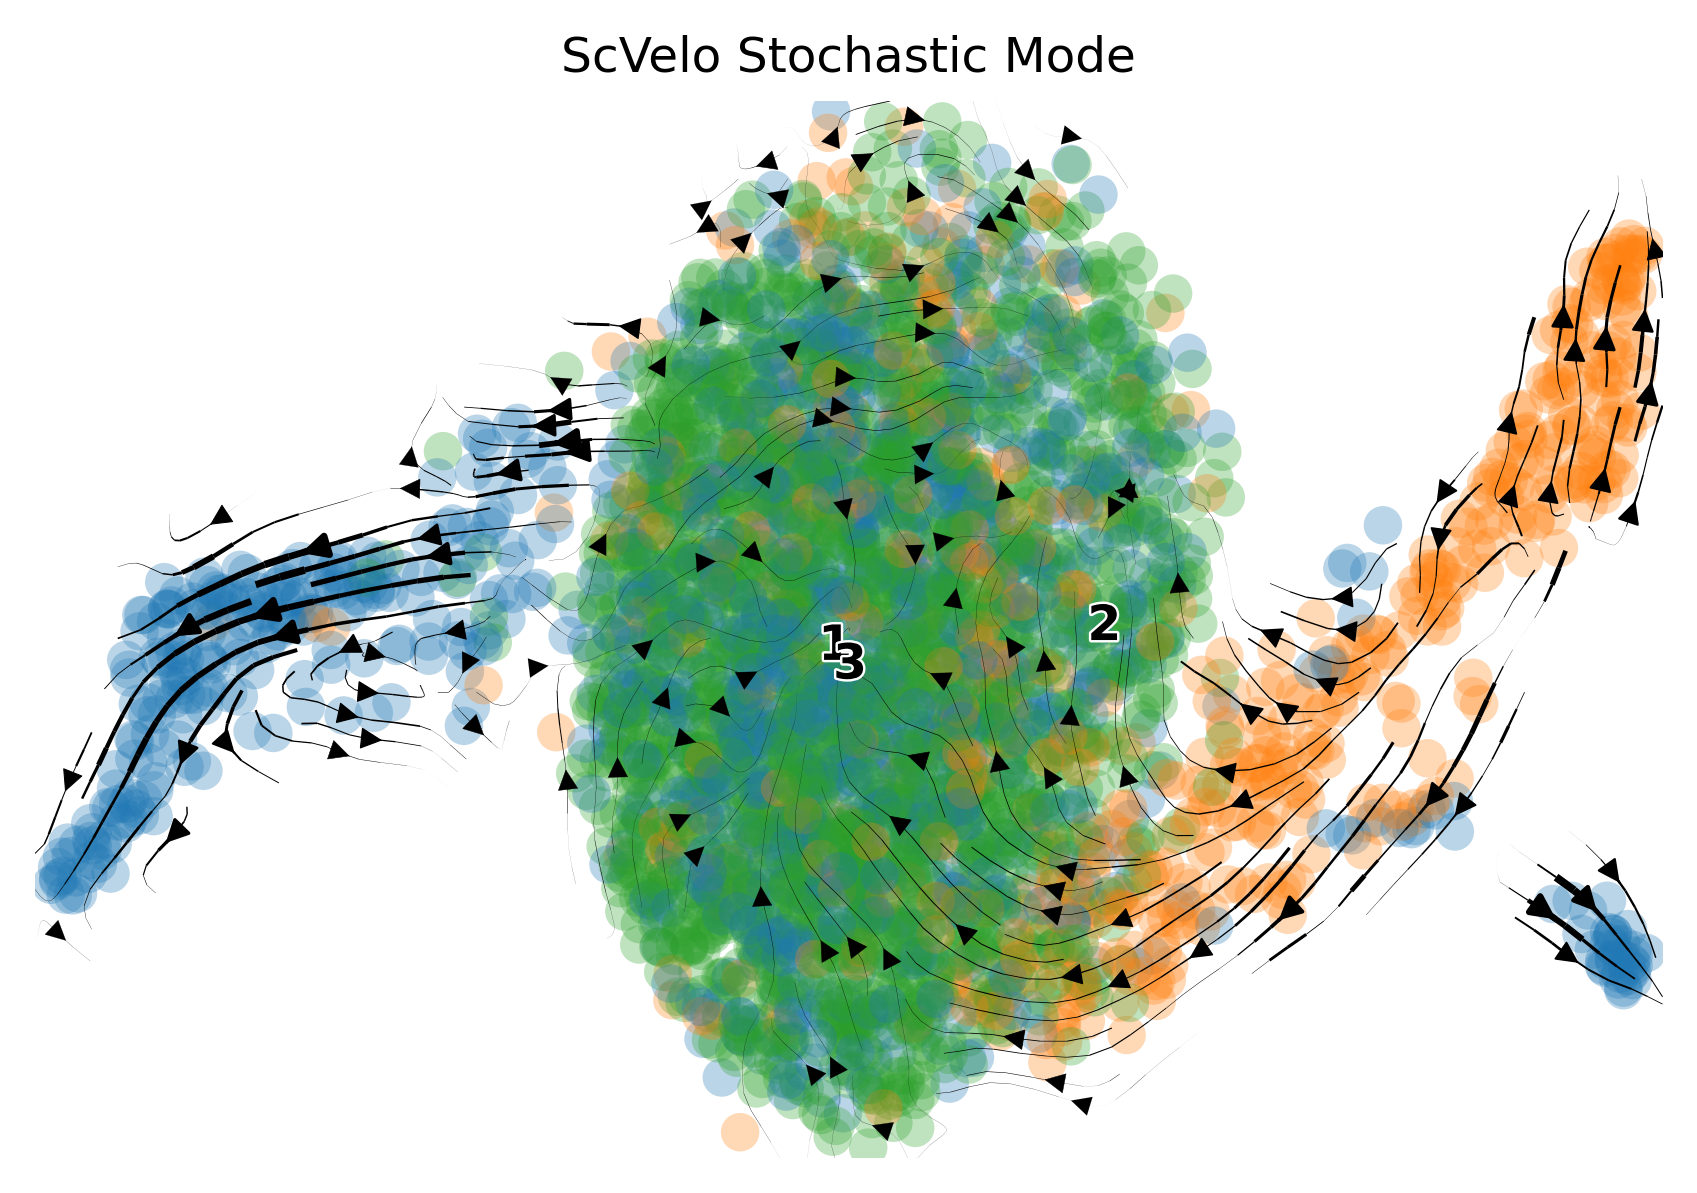

# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.15110905, ('3', '2'): 0.08070849}
Total Mean: 0.11590877175331116
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.79888743, ('3', '2'): 0.8207456}
Total Mean: 0.8098164796829224
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.10778322538849838, ('3', '2'): 0.07385793843483786}
Total Mean: 0.09082058191166811
# In-cluster Coherence
{'1': 0.80496264, '2': 0.85452604, '3': 0.83365995}
Total Mean: 0.8310495018959045
# In-cluster Confidence
{'1': 0.7199736277122568, '2': 0.7906060736097675, '3': 0.780544162448959}
Total Mean: 0.7637079545903278


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=['monocle_branch_id'],
                                 dpi=350,
                                title='ScVelo Stochastic Mode', save="scEU_stochastical.png")

exp_metrics['stc_mode'] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

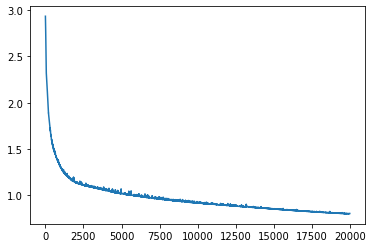

0.8041420578956604


In [9]:
main_AE(args)

In [10]:
n_cells, n_genes = adata.X.shape
z_dim = args.z_dim
g_rep_dim = args.g_rep_dim
h_dim = args.h_dim
k_dim = args.k_dim
    
G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())

model = get_veloAE(
                 adata, 
                 z_dim, 
                 n_genes, 
                 n_cells, 
                 h_dim, 
                 k_dim, 
                 G_embeddings=G_embeddings, 
                 g_rep_dim=g_rep_dim,
                 device=device
                )
model.load_state_dict(torch.load(args.model_name))
model = model.to(device)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scEU_pojection.png


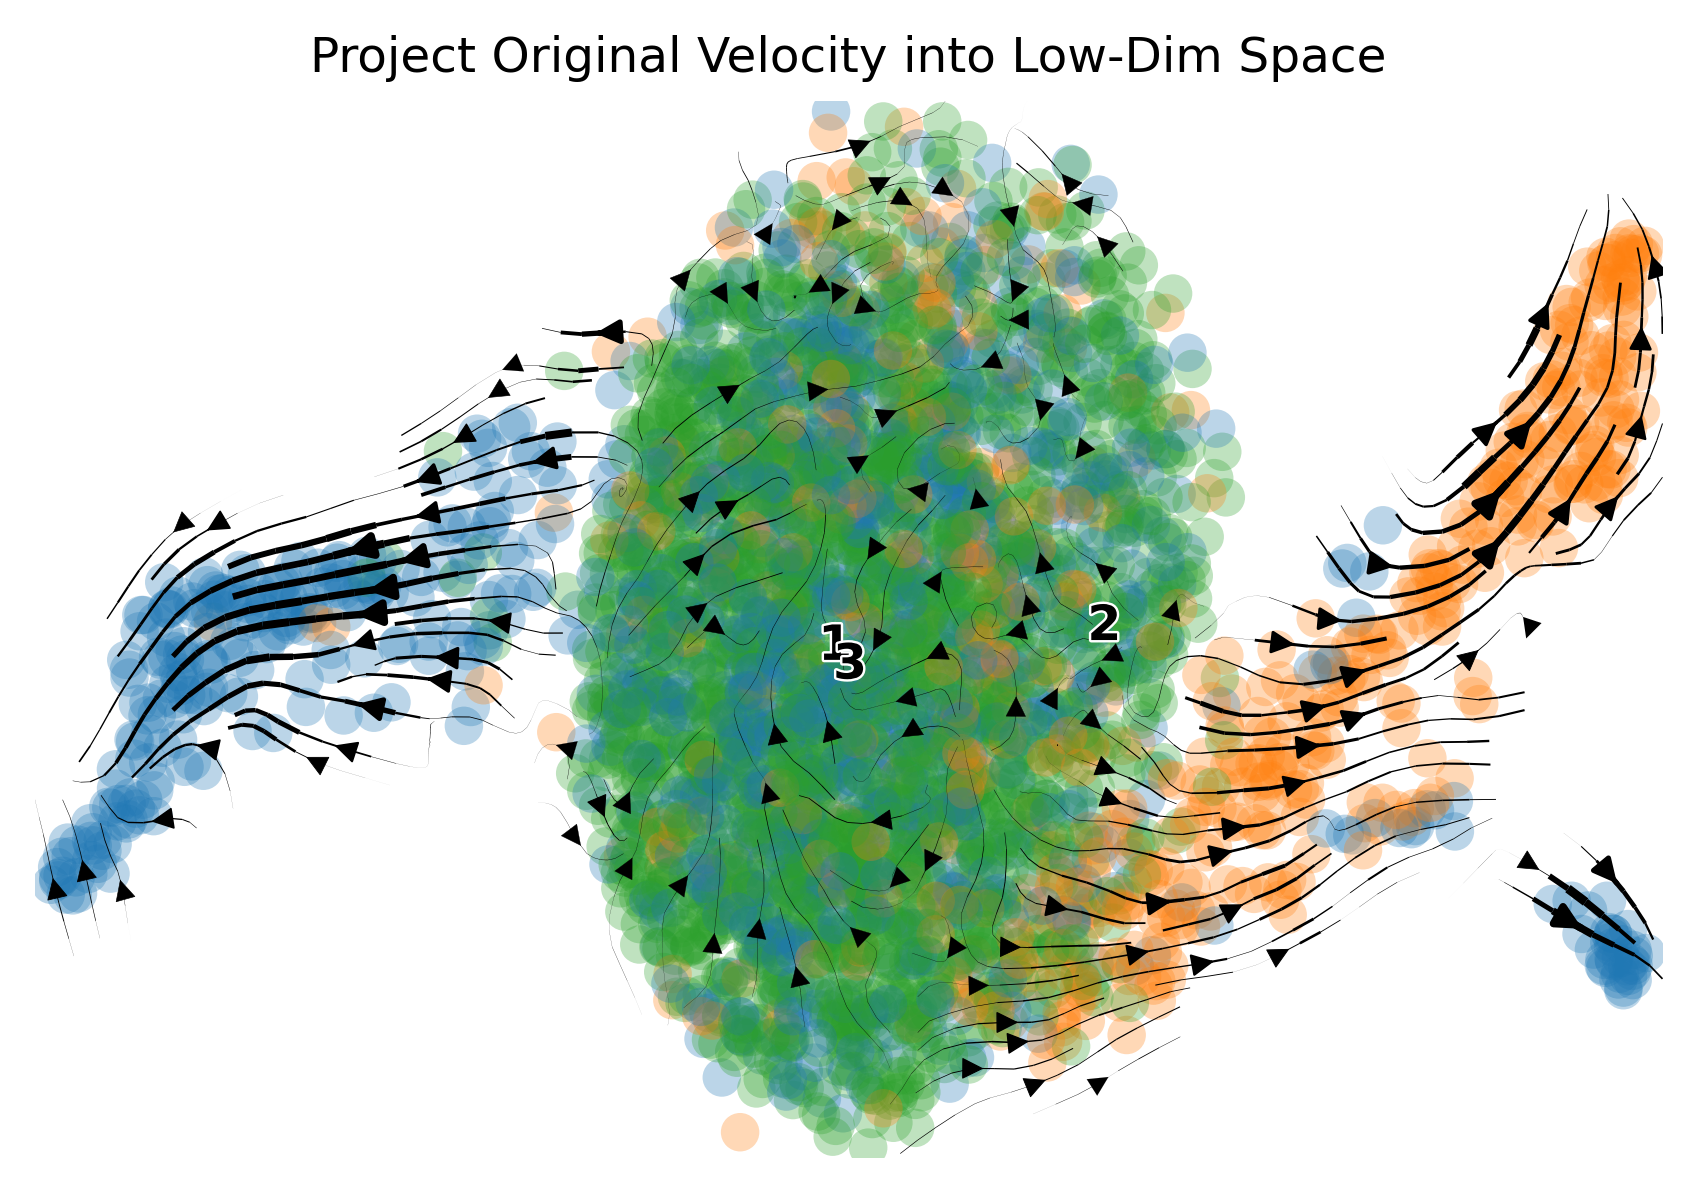

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.13379247, ('3', '2'): 0.1202328}
Total Mean: 0.12701264023780823
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.97375995, ('3', '2'): 0.9774709}
Total Mean: 0.975615382194519
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.057325711290431555, ('3', '2'): 0.13318143638106755}
Total Mean: 0.09525357383574956
# In-cluster Coherence
{'1': 0.9684329, '2': 0.9734233, '3': 0.97821426}
Total Mean: 0.9733567833900452
# In-cluster Confidence
{'1': 0.9642512820019628, '2': 0.9683213188247618, '3': 0.9769421049018404}
Total Mean: 0.9698382352428551


In [11]:
def exp(adata, exp_metrics):
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s

    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['monocle_branch_id'],
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    save='scEU_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
exp(adata, exp_metrics)

In [12]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)